✅ Device set to: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 Copying data to local disk... (Speed Up!)
📂 Data Path: /content/chest_xray_data/chest_xray
🚀 Training for 20 epochs...
Epoch 01 | Train Acc: 0.9548 | Val Acc: 0.8125
Epoch 02 | Train Acc: 0.9747 | Val Acc: 0.8125
Epoch 03 | Train Acc: 0.9806 | Val Acc: 0.9375
Epoch 04 | Train Acc: 0.9803 | Val Acc: 0.8750
Epoch 05 | Train Acc: 0.9877 | Val Acc: 0.8750
Epoch 06 | Train Acc: 0.9849 | Val Acc: 0.9375
Epoch 07 | Train Acc: 0.9893 | Val Acc: 0.7500
Epoch 08 | Train Acc: 0.9873 | Val Acc: 0.8125
Epoch 09 | Train Acc: 0.9927 | Val Acc: 1.0000
Epoch 10 | Train Acc: 0.9879 | Val Acc: 0.8750
Epoch 11 | Train Acc: 0.9944 | Val Acc: 0.9375
Epoch 12 | Train Acc: 0.9912 | Val Acc: 0.8750
Epoch 13 | Train Acc: 0.9904 | Val Acc: 0.9375
Epoch 14 | Train Acc: 0.9929 | Val Acc: 1.0000
Epoch 15 | Train Acc: 0.9946 | Val Acc: 0.9375
Epoch 16 | Train Acc: 0

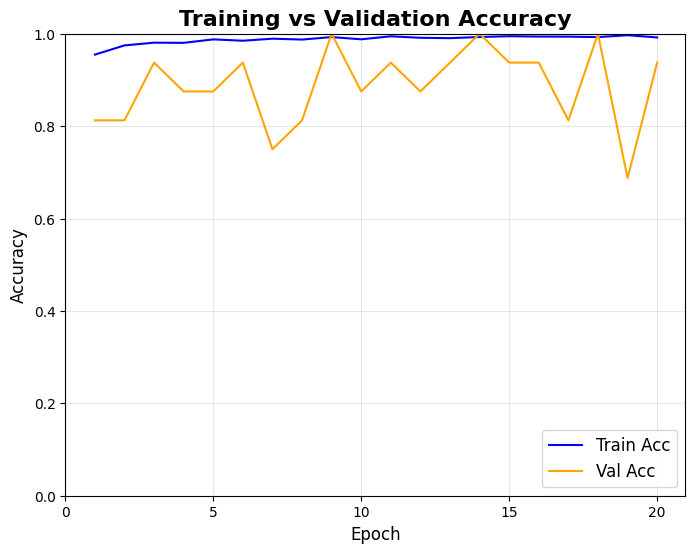


📊 [Graph 2] Loss Curve


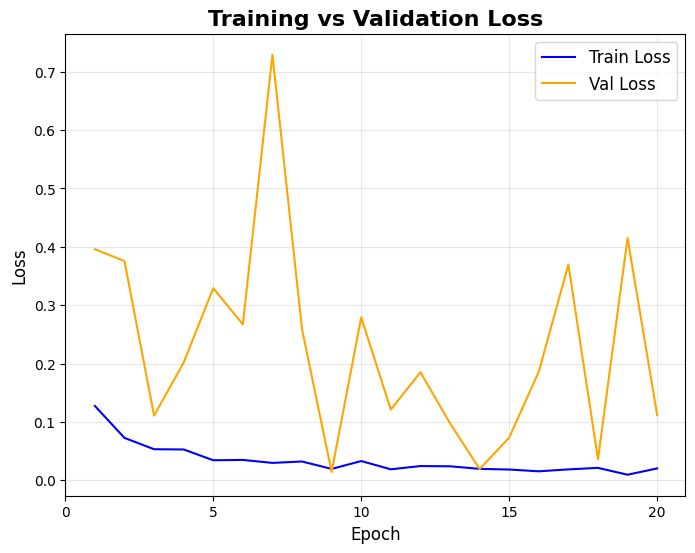


📊 [Chart] Confusion Matrix


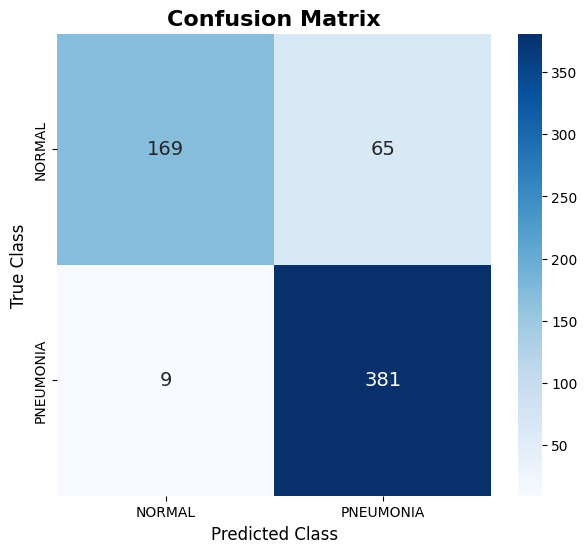


📄 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.72      0.82       234
   PNEUMONIA       0.85      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.87       624
weighted avg       0.89      0.88      0.88       624


📸 [Demo] Grad-CAM Inference


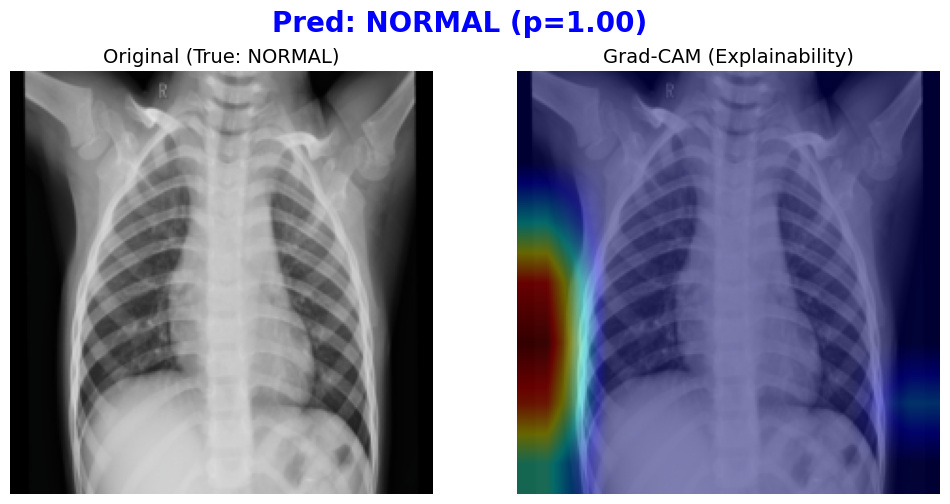

In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time
import shutil
import zipfile
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix

# ==========================================
# 1. 환경 설정 및 시드 고정
# ==========================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

CONFIG = {
    "seed": 42,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "image_size": 224,
    "batch_size": 16,
    "num_epochs": 20,
    "lr": 1e-4,
    "drive_zip_path": "/content/drive/MyDrive/chest-xray-pneumonia.zip",
    "local_path": "/content/chest_xray_data",
    "data_path": ""
}

set_seed(CONFIG["seed"])
print(f"✅ Device set to: {CONFIG['device']}")

# ==========================================
# 2. 데이터셋 준비 (고속 로딩)
# ==========================================
try:
    drive.mount('/content/drive')
except:
    pass

if os.path.exists(CONFIG["drive_zip_path"]):
    print(f"🚀 Copying data to local disk... (Speed Up!)")
    local_zip = '/content/temp_chest_xray.zip'
    shutil.copy(CONFIG["drive_zip_path"], local_zip)

    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(CONFIG["local_path"])

    # 데이터 경로 자동 탐색
    possible_path = os.path.join(CONFIG["local_path"], "chest_xray")
    if os.path.exists(os.path.join(possible_path, "train")):
        CONFIG["data_path"] = possible_path
    elif os.path.exists(os.path.join(CONFIG["local_path"], "train")):
        CONFIG["data_path"] = CONFIG["local_path"]
    else:
        nested = os.path.join(possible_path, "chest_xray")
        CONFIG["data_path"] = nested if os.path.exists(os.path.join(nested, "train")) else CONFIG["local_path"]
    print(f"📂 Data Path: {CONFIG['data_path']}")
else:
    print("⚠️ Zip file not found. Falling back to Drive path.")
    CONFIG["data_path"] = "/content/drive/MyDrive/chest_xray"

# ==========================================
# 3. 데이터 로더
# ==========================================
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(CONFIG["data_path"], x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=CONFIG["batch_size"], shuffle=(x=='train'), num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes # ['NORMAL', 'PNEUMONIA']

# ==========================================
# 4. 모델 정의 (ResNet50)
# ==========================================
def get_model():
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, 1)
    model = model.to(CONFIG["device"])
    return model

model = get_model()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])

# ==========================================
# 5. 학습 루프
# ==========================================
def train_model(model, num_epochs=20):
    best_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    print(f"🚀 Training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()

            r_loss, r_corrects = 0.0, 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(CONFIG["device"])
                labels = labels.to(CONFIG["device"]).float().unsqueeze(1)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.sigmoid(outputs) > 0.5
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                r_loss += loss.item() * inputs.size(0)
                r_corrects += torch.sum(preds == labels.data)

            epoch_loss = r_loss / dataset_sizes[phase]
            epoch_acc = r_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_wts = copy.deepcopy(model.state_dict())

        # 로그 출력 (간소화)
        print(f"Epoch {epoch+1:02d} | Train Acc: {history['train_acc'][-1]:.4f} | Val Acc: {history['val_acc'][-1]:.4f}")

    model.load_state_dict(best_wts)
    return model, history

model, history = train_model(model, num_epochs=CONFIG["num_epochs"])

# ==========================================
# 6. [발표용] 시각화 코드 (수정 사항 반영)
# ==========================================

# 6-1. Accuracy Graph
def plot_accuracy(history):
    epochs = range(1, len(history['train_acc']) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc') # 파란색 실선
    plt.plot(epochs, history['val_acc'], 'orange', label='Val Acc') # 주황색 실선

    plt.title('Training vs Validation Accuracy', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, 1.0) # Y축 0~1 정규화
    plt.xticks(epochs) # X축 1~20 모두 표시 (또는 간격 조정 가능)
    if len(epochs) > 10: # Epoch이 많으면 5단위로 끊기
        plt.xticks(np.arange(0, len(epochs)+1, 5))

    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

# 6-2. Loss Graph
def plot_loss(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'orange', label='Val Loss')

    plt.title('Training vs Validation Loss', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12) # 값 그대로
    if len(epochs) > 10:
        plt.xticks(np.arange(0, len(epochs)+1, 5))

    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

print("\n📊 [Graph 1] Accuracy Curve")
plot_accuracy(history)
print("\n📊 [Graph 2] Loss Curve")
plot_loss(history)

# 6-3. Confusion Matrix (Test Set)
def plot_confusion_matrix(model, dataloader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(CONFIG["device"])
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(7, 6))
    # 행=True Class, 열=Predicted Class
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'],
                annot_kws={"size": 14})

    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.show()

    print("\n📄 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

print("\n📊 [Chart] Confusion Matrix")
plot_confusion_matrix(model, dataloaders['test'])

# 6-4. Grad-CAM & Prediction Demo
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x):
        self.gradients = None; self.activations = None
        output = self.model(x)
        prob = torch.sigmoid(output)
        score = output[0][0]
        self.model.zero_grad()
        score.backward()

        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights): cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam, prob.item()

def show_gradcam_demo(model, dataset):
    model.eval()
    grad_cam = GradCAM(model, model.layer4)

    # 임의의 이미지 추출
    idx = random.randint(0, len(dataset)-1)
    img_tensor, label = dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(CONFIG["device"]).requires_grad_(True)

    mask, prob_pneumonia = grad_cam(input_tensor)

    # 이미지 역정규화
    img_np = img_tensor.cpu().detach().numpy().transpose(1, 2, 0)
    img_np = np.clip(img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

    # Heatmap 적용
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]
    cam_img = heatmap * 0.4 + img_np * 0.6

    # 확률 및 텍스트 설정 (요청: p=0.92)
    # 모델 출력 확률(prob_pneumonia)이 0.5보다 크면 PNEUMONIA, 아니면 NORMAL
    if prob_pneumonia > 0.5:
        pred_label = "PNEUMONIA"
        display_prob = prob_pneumonia
    else:
        pred_label = "NORMAL"
        display_prob = 1 - prob_pneumonia # Normal일 확률로 변환하여 보여줄 경우
        # 만약 모델의 Raw output(폐렴일 확률)을 그대로 보여주고 싶다면 아래 줄 사용
        # display_prob = prob_pneumonia

    # 발표용 텍스트 포맷 (Pred: CLASS (p=0.xx))
    # 여기서는 '예측된 클래스에 대한 확신도'를 표기하도록 설정했습니다.
    title_text = f"Pred: {pred_label} (p={display_prob:.2f})"
    color = "red" if pred_label == "PNEUMONIA" else "blue"

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Original (True: {class_names[label]})", fontsize=14)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cam_img)
    plt.title("Grad-CAM (Explainability)", fontsize=14)
    plt.axis('off')

    plt.suptitle(title_text, fontsize=20, color=color, fontweight='bold', y=0.95)
    plt.show()

print("\n📸 [Demo] Grad-CAM Inference")
show_gradcam_demo(model, image_datasets['test'])